In [1]:
from web3 import Web3
import pandas as pd
import datetime
from concurrent.futures import ProcessPoolExecutor
import numpy as np
from datetime import datetime
import logging, os, json
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [61]:
def remove_outliers(df):
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            lower_bound = df[column].quantile(0.05)
            upper_bound = df[column].quantile(0.95)
            df = df.loc[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df.reset_index(drop=True)

def remove_out_col(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Adjust the multiplier according to your threshold requirement
    # 1.5 is commonly used for outlier detection, but for a 90% threshold,
    # you might want to use a smaller or larger number based on your specific needs
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtering the DataFrame to remove outliers
    cleaned_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return cleaned_df


# Eden Memepool data

In [124]:
df = pd.read_csv('block_data/2024-01-01.csv')
df = df.set_index('timestamp_ms').sort_index()
# timestamp_ms = included_block_timestamp_ms - df.inclusion_delay_ms
df = df.rename(columns={'included_at_block_height':'block_number'})
df = df[df['block_number']!=0]
df

,hash,chain_id,from,to,value,nonce,gas,gas_price,gas_tip_cap,gas_fee_cap,data_size,data_4bytes,sources,block_number,included_block_timestamp_ms,inclusion_delay_ms
timestamp_ms,,,,,,,,,,,,,,,,
1704067200050,0x676fa7aaa628c149ccf55b710c91c0e0893b7c61cc71...,1,0xcac0f1a06d3f02397cfb6d7077321d73b504916e,0x7776607e2e0bd61052e60d59f1fdd11dfbec27e8,10918525483922891384,637,90993,18913996280,3000000000,18913996280,388,0xb9e9a5ef,bloxroute chainbound local eden apool mempoolguru,18908895,1704067211000,10950
1704067200092,0x09278b07b93bb18ca2572e45344fec2ae839a8e91a6c...,1,0xf89d7b9c864f589bbf53a82105107622b35eaa40,0xf4683143dff0741dd4d9bfcbc04686cfa6f5f0dd,2261880000000000000,2022339,90000,200000000000,2000000000,200000000000,0,NaN,local bloxroute eden chainbound apool mempoolguru,18908895,1704067211000,10908
1704067200198,0xadb66057a008433dac03c7d4347b3a064f888d9cba57...,1,0xd8aa8f3be2fb0c790d3579dcf68a04701c1e33db,0x0ed1bcc400acd34593451e76f854992198995f52,0,361726,2800000,22246710128,2000000000,22246710128,4,0x98e5b12a,chainbound bloxroute eden local apool mempoolguru,18908895,1704067211000,10802
1704067200251,0xf0b6fa72dfd0295b6e3c0486314ef91f17500c43475d...,1,0xd8aa8f3be2fb0c790d3579dcf68a04701c1e33db,0x2659dbe2d2e6f88063027af4eec9d1d1b2fc9789,0,361727,2800000,22246710128,2000000000,22246710128,4,0x98e5b12a,local bloxroute chainbound eden apool mempoolguru,18908895,1704067211000,10749
1704067200271,0x7707050f901524dbe363a06ebbccc5096c9b13f493f3...,1,0xd8aa8f3be2fb0c790d3579dcf68a04701c1e33db,0x63c856b816dcfa22fa403d8f62e0517db6f3a891,0,361728,2800000,22246710128,2000000000,22246710128,4,0x98e5b12a,local eden bloxroute chainbound apool mempoolguru,18908895,1704067211000,10729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704153599711,0x9ef29cd292ad0a8c0cf6aae8eca8a4634956e58432f4...,1,0x271c3b8cb318d2647ee7e24ebd2ba2e6cd06fc59,0xf57e7e7c23978c3caec3c3548e3d615c346e79ff,0,691,53699,11686505442,50000000,11686505442,68,0x095ea7b3,local bloxroute chainbound eden apool,18916002,1704153611000,11289
1704153599783,0xa7f300740d1a43312f69067a6cf73812e7388268f34b...,1,0x68a04017e697361ceb112316575cb6c70cf7564d,0x1111111254eeb25477b68fb85ed929f73a960582,0,36,264336,24751071977,1248928023,24751071977,744,0x12aa3caf,chainbound bloxroute local eden apool,18916002,1704153611000,11217
1704153599875,0x4f75b76227d34d6fd25212fb97f12b7380f3978d0f2b...,1,0x1155ee2646693a9c6df095f08a3bf39ee9580728,0x003af52ba25645843f42ecf5cefc06f58763d8d1,0,755,90196,12000000000,12000000000,12000000000,36,0x19165587,bloxroute chainbound local eden mempoolguru apool,18916002,1704153611000,11125


In [106]:
print(df['gas_price'].all() == df['gas_fee_cap'].all(), 'Gas tip is the gas')
(df['gas_price'] == df['gas_tip_cap']).sum()*100/len(df)

True Gas tip is the gas


23.691877627017725

In [107]:
sub = df[['gas', 'gas_price', 'gas_tip_cap', 'block_number']] #, 'included_block_timestamp_ms', 'inclusion_delay_ms']]
sub.reset_index()

,timestamp_ms,gas,gas_price,gas_tip_cap,block_number
0,1704067200050,90993,18913996280,3000000000,18908895
1,1704067200092,90000,200000000000,2000000000,18908895
2,1704067200198,2800000,22246710128,2000000000,18908895
3,1704067200251,2800000,22246710128,2000000000,18908895
4,1704067200271,2800000,22246710128,2000000000,18908895
...,...,...,...,...,...
990900,1704153599711,53699,11686505442,50000000,18916002
990901,1704153599783,264336,24751071977,1248928023,18916002
990902,1704153599875,90196,12000000000,12000000000,18916002
990903,1704153599930,21000,11467566922,11467566922,18916002


In [108]:
sub.loc[:, 'gasPrice_eth'] = sub['gas_price'] * 10**-18
sub.loc[:, 'tcost_eth'] = sub['gasPrice_eth'] * sub['gas']

numeric_cols = ['gas_price', 'gas', 'gasPrice_eth', 'tcost_eth']
grouped = sub.groupby(['block_number'], as_index=True)[numeric_cols]

aggregations = {
    'tcost_eth': ['count', 'max', 'std', 'skew', 'mean', 'min'],
    'gas': ['count', 'max', 'std', 'skew', 'mean', 'min', pd.Series.kurt],
    'gasPrice_eth': ['count', 'max', 'std', 'skew', 'mean', 'min', pd.Series.kurt],
}

result = grouped.agg(aggregations)
result.dropna()


/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_2125/2478728970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub.loc[:, 'gasPrice_eth'] = sub['gas_price'] * 10**-18
/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_2125/2478728970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub.loc[:, 'tcost_eth'] = sub['gasPrice_eth'] * sub['gas']


tcost_eth                                                     \
                 count       max       std       skew      mean       min   
block_number                                                                
18908895           206  0.141969  0.015762   5.374282  0.005573  0.000264   
18908896           208  0.168000  0.021056   5.389772  0.006815  0.000263   
18908897           104  0.110430  0.011824   7.396939  0.004177  0.000276   
18908898           127  0.125384  0.013608   5.916411  0.006233  0.000266   
18908899           114  0.900000  0.085507  10.062372  0.014245  0.000260   
...                ...       ...       ...        ...       ...       ...   
18915998           128  0.042666  0.005349   4.489476  0.003116  0.000249   
18915999           108  3.700000  0.355858  10.365659  0.039185  0.000252   
18916000           111  0.175700  0.026826   4.831349  0.008576  0.000243   
18916001           154  0.057588  0.006560   5.102671  0.002895  0.000237   
18916002            30  0.006581  0.001672   2.176019  0.001392  0.000231   

               gas                                                           \
             count       max           std       skew           mean    min   
block_number                                                                  
18908895       206   8000000  7.726501e+05   6.856263  244165.548544  21000   
18908896       208   5300000  8.375199e+05   5.302059  267886.884615  21000   
18908897       104   5300000  5.359793e+05   8.797708  166087.096154  21000   
18908898       127   5000000  4.977504e+05   7.802140  198834.440945  21000   
18908899       114   3000000  4.147989e+05   4.217257  231831.570175  21000   
...            ...       ...           ...        ...            ...    ...   
18915998       128   1890924  2.237794e+05   4.754731  152576.976562  21000   
18915999       108  18500000  1.829773e+06   9.443227  352329.648148  21000   
18916000       111   2142069  2.929158e+05   5.342023  155371.450450  21000   
18916001       154   5131285  4.348509e+05  10.115655  145479.642857  21000   
18916002        30    291672  8.900781e+04   1.093781   97327.866667  21000   

                         gasPrice_eth                                   \
                    kurt        count           max           std skew   
block_number                                                             
18908895       57.406988          206  2.000000e-07  2.671462e-08  0.0   
18908896       28.419430          208  4.000000e-07  4.170378e-08  0.0   
18908897       83.734069          104  1.182380e-06  1.149660e-07  0.0   
18908898       70.926510          127  1.020000e-07  2.700868e-08  0.0   
18908899       21.892434          114  9.000000e-07  8.713228e-08  0.0   
...                  ...          ...           ...           ...  ...   
18915998       30.999477          128  1.000000e-06  8.994021e-08  0.0   
18915999       92.972032          108  4.000000e-07  4.629134e-08  0.0   
18916000       32.650685          111  9.990000e-07  1.281012e-07  0.0   
18916001      114.683528          154  2.000000e-07  2.537928e-08  0.0   
18916002       -0.144591           30  2.475107e-08  3.437518e-09  0.0   

                                               
                      mean           min kurt  
block_number                                   
18908895      2.571215e-08  1.258502e-08  0.0  
18908896      2.898171e-08  1.243841e-08  0.0  
18908897      3.466552e-08  1.316130e-08  0.0  
18908898      2.844578e-08  1.253457e-08  0.0  
18908899      3.366051e-08  1.239441e-08  0.0  
...                    ...           ...  ...  
18915998      2.867847e-08  1.164339e-08  0.0  
18915999      2.524360e-08  1.200000e-08  0.0  
18916000      4.582729e-08  1.148855e-08  0.0  
18916001      1.947452e-08  1.111866e-08  0.0  
18916002      1.296436e-08  1.089104e-08  0.0  

[7084 rows x 20 columns]

In [37]:
res = remove_outliers(result)

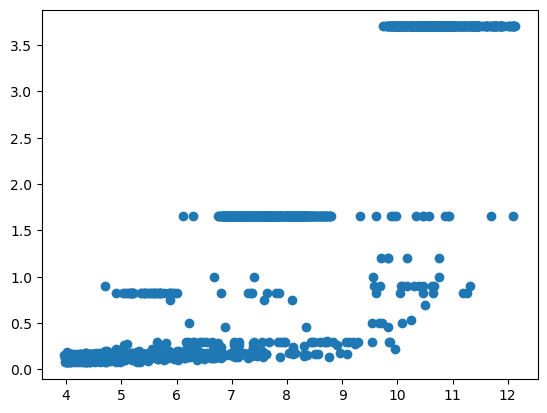

In [38]:
plt.scatter(res['tcost_eth']['skew'], res['tcost_eth']['max'])

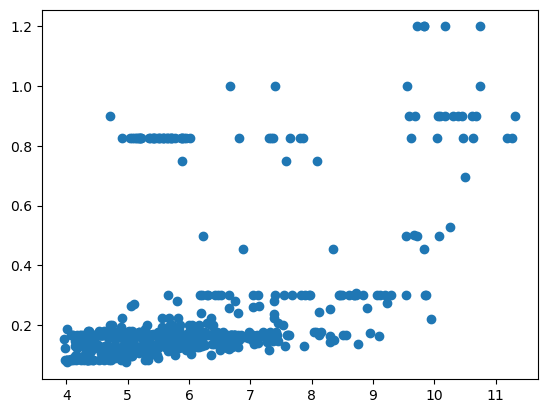

In [43]:
sub = res[res['tcost_eth']['max']<res['tcost_eth']['max'].quantile(0.7)]
plt.scatter(sub['tcost_eth']['skew'], sub['tcost_eth']['max'])

# block transaction data

In [90]:
aggregated_df = pd.DataFrame()

chunk_size = 10**5

file_path = 'block_data/compiled_eth_tx_small.csv'

for chunk in pd.read_csv(file_path, chunksize=chunk_size,  encoding='ISO-8859-1', on_bad_lines='skip', quotechar='"', escapechar='\\'):
    chunk['gasPrice_eth'] = chunk['gas_price_gwei'] * 10**-9
    chunk['tcost_eth']    = chunk['gasPrice_eth'] * chunk['gas_used']
    
    numeric_cols = ['gas_price_gwei', 'gas_used', 'gasPrice_eth', 'tcost_eth']
    grouped = chunk.groupby(['block_number'], as_index=True)[numeric_cols]

    chunk_aggregated = grouped.agg(['count', 'max', 'std', 'skew', 'mean', 'min'])
    aggregated_df = pd.concat([aggregated_df, chunk_aggregated])
    
tmp = aggregated_df.copy()
tmp.columns = ['_'.join(col).strip() for col in tmp.columns.values]
tmp.to_csv('block_data/block_stats.csv')
aggregated_df.drop_duplicates()

gas_price_gwei                                               \
                      count         max        std       skew       mean   
block_number                                                               
18937472                145   75.000000   7.683449   4.882185  19.632337   
18937473                142  149.732461  14.229585   6.697967  20.612597   
18937474                118   45.391739   4.452365   3.727715  18.825592   
18937475                127  147.203487  12.874626   8.403745  19.417773   
18937476                251  374.966944  23.576517  13.912057  19.786731   
...                     ...         ...        ...        ...        ...   
18937815                 13   32.716942   6.204909   0.049452  23.788710   
18937999                 25   30.776138   0.029587   0.792073  30.722098   
18938320                195   90.000000   8.736245   5.184250  18.169719   
18937815                124   19.880000   1.010781   1.728710  16.694231   
18938321                148  335.345259  26.378159  11.954765  18.489135   

                        gas_used                                    ...  \
                    min    count      max            std      skew  ...   
block_number                                                        ...   
18937472      16.744342      145  1575687  168405.311521  6.668442  ...   
18937473      16.494987      142  1870412  183105.571228  6.965168  ...   
18937474      16.624383      118   728368  115110.464771  2.664071  ...   
18937475      16.246220      127   890466  107480.071404  3.803718  ...   
18937476      15.827133      251  1325758  133079.453319  6.224304  ...   
...                 ...      ...      ...            ...       ...  ...   
18937815      16.274741       13   252138   65333.622659  2.350443  ...   
18937999      30.676138       25   289087   79431.025781  2.077145  ...   
18938320      14.579046      195   993736  133611.290468  4.421120  ...   
18937815      16.072970      124  1308422  155222.754307  4.843809  ...   
18938321      14.898094      148  1047783  130161.602220  3.648364  ...   

              gasPrice_eth                                  tcost_eth  \
                       std skew          mean           min     count   
block_number                                                            
18937472      7.683449e-09  0.0  1.963234e-08  1.674434e-08       145   
18937473      1.422958e-08  0.0  2.061260e-08  1.649499e-08       142   
18937474      4.452365e-09  0.0  1.882559e-08  1.662438e-08       118   
18937475      1.287463e-08  0.0  1.941777e-08  1.624622e-08       127   
18937476      2.357652e-08  0.0  1.978673e-08  1.582713e-08       251   
...                    ...  ...           ...           ...       ...   
18937815      6.204909e-09  0.0  2.378871e-08  1.627474e-08        13   
18937999      2.958746e-11  0.0  3.072210e-08  3.067614e-08        25   
18938320      8.736245e-09  0.0  1.816972e-08  1.457905e-08       195   
18937815      1.010781e-09  0.0  1.669423e-08  1.607297e-08       124   
18938321      2.637816e-08  0.0  1.848913e-08  1.489809e-08       148   

                                                                
                   max       std      skew      mean       min  
block_number                                                    
18937472      0.034262  0.003491  6.734353  0.001820  0.000352  
18937473      0.031989  0.004237  5.259441  0.002393  0.000346  
18937474      0.013201  0.002042  2.451081  0.001926  0.000349  
18937475      0.021199  0.002707  4.399028  0.001879  0.000341  
18937476      0.040511  0.003555  6.995124  0.001903  0.000332  
...                ...       ...       ...       ...       ...  
18937815      0.007835  0.002033  2.849432  0.001571  0.000426  
18937999      0.008897  0.002443  2.076968  0.002119  0.000644  
18938320      0.015481  0.002179  3.649115  0.001580  0.000306  
18937815      0.021085  0.002552  4.616874  0.001647  0.000338  
18938321      0.050098  0.004

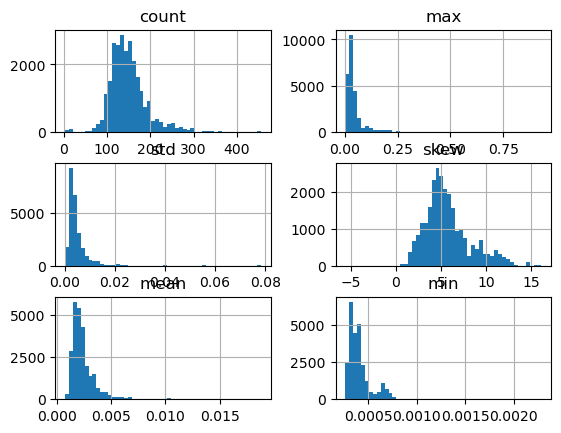

In [70]:
aggregated_df['tcost_eth'].hist(bins=50)
plt.show()

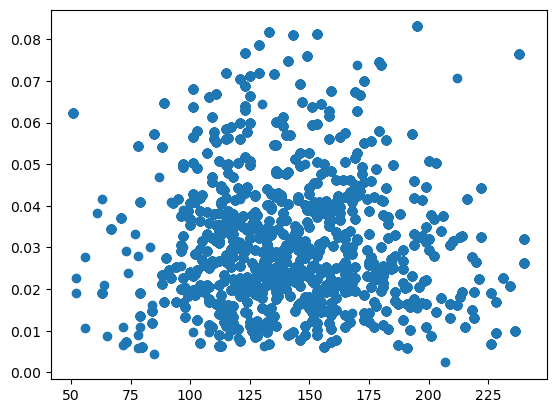

In [78]:
f1 = 'count'
f2 = 'max'
agg = remove_out_col(aggregated_df['tcost_eth'], f1)
agg = remove_out_col(agg, f2)
plt.scatter(agg[f1].values, agg[f2].values)

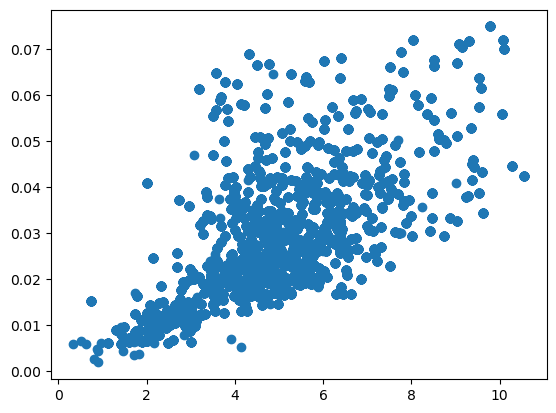

In [79]:
# perfect linearilty
f1 = 'skew'
f2 = 'max'
agg = remove_out_col(aggregated_df['tcost_eth'], f1)
agg = remove_out_col(agg, f2)
plt.scatter(agg[f1].values, agg[f2].values)

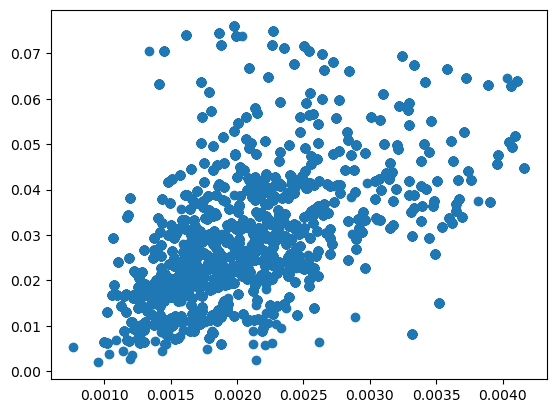

In [81]:
# here we can see its not linear
f1 = 'mean'
f2 = 'max'
agg = remove_out_col(aggregated_df['tcost_eth'], f1)
agg = remove_out_col(agg, f2)
plt.scatter(agg[f1].values, agg[f2].values)

# Parquet file

In [128]:
import pandas as pd

file_path = 'data_UV3_WETH_USDC_January2024.pkl'
df_uv3 = pd.read_pickle(file_path)
df_uv3 = df_uv3.rename(columns={'timestamp':'timestamp_ms'})
df_uv3 = df_uv3.rename(columns={'blockNumber':'block_number'})

df_uv3

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp_ms,gasUsed,gasPrice_wei,gasPrice_eth,block_number,symbol0,symbol1,price,tcost_usd,time
0,5000.000000,-1.934507,5002.867230,0x075487028749481cc7c46e571b8ae2e232a76dfd,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3beeab9d5624e487045e01d12332975204a04a8a,1.704931e+09,367396,5.217855e+10,5.217855e-08,18979974,USDC,WETH,2583.524433,49.526656,2024-01-10 23:59:23
1,10.900000,-0.004217,10.906397,0x51bdc9443f72c330203e32b7fbf3e8735258c861,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704931e+09,232423,5.217855e+10,5.217855e-08,18979974,USDC,WETH,2583.524433,31.331680,2024-01-10 23:59:23
2,-29913.316850,11.583530,29943.444234,0xda59e985fc9a6c7f3f8e5c92038a1eeacfcfc297,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xda59e985fc9a6c7f3f8e5c92038a1eeacfcfc297,1.704931e+09,503475,5.533007e+10,5.533007e-08,18979973,USDC,WETH,2583.524433,71.970032,2024-01-10 23:59:11
3,10750.000000,-4.158200,10754.884350,0x68465085891466fae2aacbf1e98c0f38d9b0ea7c,0xe592427a0aece92de3edee1f18e0157c05861564,0xdef171fe48cf0115b1d80b88dc8eab59176fee57,1.704931e+09,1376471,5.022922e+10,5.022922e-08,18979972,USDC,WETH,2584.299568,178.676049,2024-01-10 23:58:59
4,893.456949,-0.345619,893.891318,0x6cfe3ffc077f69e2cf42233360450c8adb2fcadc,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704931e+09,228119,5.131698e+10,5.131698e-08,18979971,USDC,WETH,2584.041164,30.249766,2024-01-10 23:58:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,855.296347,-0.375782,855.430033,0xd1f8d5b125314d29ccc22b5015f55705bcd465d6,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704065e+09,413108,1.280832e+10,1.280832e-08,18908707,USDC,WETH,2274.956396,12.037294,2023-12-31 23:22:35
59996,-43781.508809,19.255109,43810.333294,0xe5c180e97ff8c6ba8cfb3902091fda6f9fb1eaf4,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x74de5d4fcbf63e00296fd95d33236b9794016631,1.704065e+09,738049,1.285888e+10,1.285888e-08,18908706,USDC,WETH,2274.956396,21.590432,2023-12-31 23:22:23
59997,1000.000000,-0.439360,1000.157687,0x6dd475d59a702a29067c7dbcfbb2a7c1c7848d0f,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704065e+09,336248,1.455888e+10,1.455888e-08,18908706,USDC,WETH,2274.956396,11.136807,2023-12-31 23:22:23
59998,-107014.041504,47.057212,107075.882157,0x675bb023e268dcc43f543620577bcacb73047f08,0xe8cfad4c75a5e1caf939fd80afcf837dde340a69,0xe8cfad4c75a5e1caf939fd80afcf837dde340a69,1.704065e+09,350000,3.516613e+10,3.516613e-08,18908702,USDC,WETH,2274.956396,28.000491,2023-12-31 23:21:35


Index(['hash', 'chain_id', 'from', 'to', 'value', 'nonce', 'gas', 'gas_price',
       'gas_tip_cap', 'gas_fee_cap', 'data_size', 'data_4bytes', 'sources',
       'block_number', 'included_block_timestamp_ms', 'inclusion_delay_ms'],
      dtype='object')

In [132]:
df[['gas', 'gas_price', 'gas_tip_cap',
    'block_number', 'included_block_timestamp_ms', 
    'inclusion_delay_ms']].merge(df_uv3[['timestamp_ms', 'gasUsed', 'gasPrice_wei',
                                         'gasPrice_eth', 'block_number', 'price', 
                                         'tcost_usd', 'time']], on='block_number', how='inner')

,gas,gas_price,gas_tip_cap,block_number,included_block_timestamp_ms,inclusion_delay_ms,timestamp_ms,gasUsed,gasPrice_wei,gasPrice_eth,price,tcost_usd,time
0,495239,12000000000,12000000000,18908903,1704067307000,106067,1.704067e+09,350000,4.366159e+10,4.366159e-08,2282.01935,34.872807,2024-01-01 00:01:47
1,495239,12000000000,12000000000,18908903,1704067307000,106067,1.704067e+09,437450,1.316626e+10,1.316626e-08,2282.01935,13.143470,2024-01-01 00:01:47
2,495239,12000000000,12000000000,18908903,1704067307000,106067,1.704067e+09,1000000,1.539995e+10,1.539995e-08,2282.01935,35.142991,2024-01-01 00:01:47
3,495239,12000000000,12000000000,18908903,1704067307000,106067,1.704067e+09,340000,1.283282e+10,1.283282e-08,2282.01935,9.956811,2024-01-01 00:01:47
4,495239,12000000000,12000000000,18908903,1704067307000,106067,1.704067e+09,440326,1.190095e+10,1.190095e-08,2282.01935,11.958464,2024-01-01 00:01:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...
781756,41725,15569065353,2000000000,18915999,1704153575000,662,1.704154e+09,730100,1.209487e+10,1.209487e-08,2351.27853,20.762873,2024-01-01 23:59:35
781757,100000,21646505442,21646505442,18915999,1704153575000,574,1.704154e+09,730100,1.209487e+10,1.209487e-08,2351.27853,20.762873,2024-01-01 23:59:35
781758,21000,13000000000,13000000000,18915999,1704153575000,561,1.704154e+09,730100,1.209487e+10,1.209487e-08,2351.27853,20.762873,2024-01-01 23:59:35
781759,21000,15323643552,100000000,18915999,1704153575000,329,1.704154e+09,730100,1.209487e+10,1.209487e-08,2351.27853,20.762873,2024-01-01 23:59:35


/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_2125/245207672.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  g = df.groupby('block_number').sum()


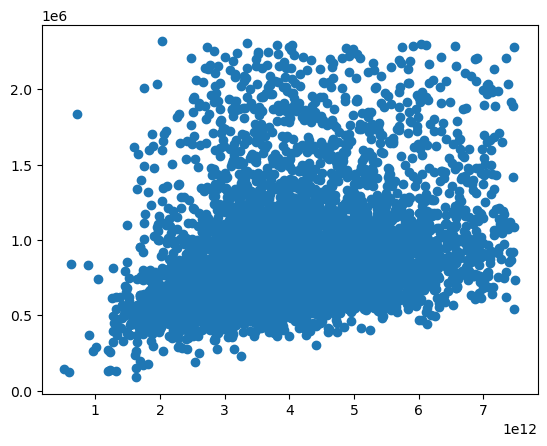

In [120]:
g = df.groupby('block_number').sum()
g = remove_out_col(remove_out_col(g, 'inclusion_delay_ms'), 'gas_price')
plt.scatter(g['gas_price'], g['inclusion_delay_ms'])

In [113]:
g

,chain_id,nonce,gas,gas_price,gas_tip_cap,gas_fee_cap,data_size,included_block_timestamp_ms,inclusion_delay_ms
block_number,,,,,,,,,
18908895,1.0,447386.058252,244165.548544,2.571215e+10,4.920669e+09,2.571215e+10,131.708738,1.704067e+12,6.584209e+03
18908896,1.0,249592.177885,267886.884615,2.898171e+10,4.434208e+09,2.898171e+10,373.500000,1.704067e+12,7.706394e+03
18908897,1.0,400478.115385,166087.096154,3.466552e+10,1.836817e+10,3.466552e+10,443.855769,1.704067e+12,5.844875e+03
18908898,1.0,902491.614173,198834.440945,2.844578e+10,3.944066e+09,2.844578e+10,761.409449,1.704067e+12,6.632598e+03
18908899,1.0,429090.412281,231831.570175,3.366051e+10,3.788596e+09,3.366051e+10,285.903509,1.704067e+12,7.101746e+03
...,...,...,...,...,...,...,...,...,...
18916067,1.0,14.500000,304012.500000,5.931513e+10,1.072500e+09,5.931513e+10,0.000000,1.704154e+12,8.064969e+07
18916120,1.0,0.000000,59142.000000,2.104250e+10,2.104250e+10,2.104250e+10,68.000000,1.704155e+12,1.271519e+07
18916594,1.0,37.500000,144738.500000,1.081681e+10,1.081681e+10,1.081681e+10,66.000000,1.704161e+12,7.657367e+06
